In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from pprint import pprint
from zen_garden.postprocess.results import Results

### Working with results of a ZenGarden run

This notebook shows some examples on how to handle the results of a `zen-garden` run. It uses the outputs of the tests as examples. Therefore, you need to run the tests via 
```
coverage run --source="zen_garden" -m pytest -v tests/testcases/run_test.py
```
to get the data.

### Reading in the results

The results can be read in using the `Results` class. This will automatically read in all relevant files, independent of the number of scenarios or if the optimization was run with perfect or myopic foresight. However, you should know what type of input you are reading in, as the output of some routines will depend on the type.

In [27]:
# This has no scenarios and perfect foresight
res_basic = Results("../outputs/test_1a/")
# Here we have two different scenarios
res_scenario = Results("../outputs/test_5a/")
# This was run with myopic foresight
res_mf = Results("../outputs/test_4g/")
# This was run with aggregated time steps and multi-year
res_ts = Results("../outputs/test_4f/")
#additional multi-scenario results
res_scenario_2 = Results("../outputs/test_5b")

### Accessing the config

The standard dictionaries, i.e. system, analysis, scenarios, solver and dict_sequence_time_steps can be accessed via the results dict.

In [28]:
# Show the deafult analysis settings
pprint(res_basic.results[None]["analysis"])
# If a scenario analysis has been conducted, the scenario-depending analysis settings can be assessed by using the scenario names
pprint(res_scenario.results["scenario_1"]["analysis"])

{'dataset': 'C:\\ZEN-garden\\tests\\testcases\\test_1a',
 'earliest_year_of_data': 1900,
 'folder_name_system_specification': 'system_specification',
 'folder_output': 'C:\\ZEN-garden\\outputs',
 'header_data_inputs': {'set_capacity_types': 'capacity_type',
                        'set_carriers': 'carrier',
                        'set_conversion_technologies': 'technology',
                        'set_dependent_carriers': 'carrier',
                        'set_edges': 'edge',
                        'set_elements': 'element',
                        'set_input_carriers': 'carrier',
                        'set_location': 'location',
                        'set_nodes': 'node',
                        'set_output_carriers': 'carrier',
                        'set_storage_technologies': 'technology',
                        'set_technologies': 'technology',
                        'set_technologies_existing': 'technology_existing',
                        'set_time_steps': 'time',
   

### Comparing the configs, parameters and variables of two result files

You can compare two result objects by using the `compare_configs`, `compare_model_parameters` and `compare_model_variables` classmethods. This can help you to get a fast overview of where two datasets are different and where the reasons for errors lie.

In [33]:
# difference between configs
diff_config = Results.compare_configs([res_basic,res_ts])
print(diff_config)
#since the config is scenario-dependent, a scenario different from the default case can be specified
diff_config = Results.compare_configs([res_scenario, res_scenario_2], scenarios="scenario_1")
diff_config

Comparing the configs of ['test_1a', 'test_4f']
{'analysis': {'dataset': {'test_1a': 'C:\\ZEN-garden\\tests\\testcases\\test_1a', 'test_4f': 'C:\\ZEN-garden\\tests\\testcases\\test_4f'}}, 'system': {'aggregated_time_steps_per_year': {'test_1a': 1, 'test_4f': 10}, 'optimized_years': {'test_1a': 1, 'test_4f': 3}, 'conduct_time_series_aggregation': {'test_1a': False, 'test_4f': True}, 'unaggregated_time_steps_per_year': {'test_1a': 1, 'test_4f': 8760}}, 'solver': {'add_duals': {'test_1a': True, 'test_4f': False}}}
Comparing the configs of ['test_5a', 'test_5b']


{'analysis': {'dataset': {'test_5a': 'C:\\ZEN-garden\\tests\\testcases\\test_5a',
   'test_5b': 'C:\\ZEN-garden\\tests\\testcases\\test_5b'}}}

In [6]:
# difference between model params
# for larger models, this can take several minutes
diff_params = Results.compare_model_parameters([res_ts,res_mf])
diff_params

Comparing the model parameters of ['test_4f', 'test_4g']


Compare parameter transport_loss_factor: 100%|██████████| 45/45 [00:01<00:00, 33.17it/s]               


{}

In [7]:
# you can also compare the model variable values. However, even a small change in the input data might have a significant impact on the results, which then leads to large differences in the variable values
diff_var = Results.compare_model_variables([res_scenario,res_scenario],scenarios=("scenario_2","scenario_4"))
diff_var

Scenario scenario_2 not in scenarios of test_5a (['scenario_', 'scenario_1']). Scenario scenario_ is selected
Scenario scenario_4 not in scenarios of test_5a (['scenario_', 'scenario_1']). Scenario scenario_ is selected
Comparing the model variables of ['test_5a', 'test_5a']


Compare variable storage_level: 100%|██████████| 36/36 [00:00<00:00, 44.78it/s]                    


{}

### Extracting individual data frames
There are three main methods to extract component (parameter and variable) values: `get_total`, `get_full_ts`, and `get_df`. It does not matter if the component is a parameter or a variable.

You can get the total value of a component for each year by using `get_total`. The full time series of a component is returned by `get_full_ts`. This reverts the time series aggregation and disaggregates the data. If the selected component is indexed by the years (e.g., `capex` or `capacity`), then the returned data is the same as from `get_total`. If you specify a `year`, only the values for this year are returned. You can select a specific `element_name`, which corresponds to the first level of the index, i.e., generally a technology or a carrier.

You can either feed `get_total` and `get_full_ts` a dataframe as returned by `get_df` or specify the component name as a string

You can access individual data frames from any component with the `get_df` method. However, the behavior differs slightly for the usecases.
If the optimization was run with perfect foresight and no scenarios, then the data frame is returned as `pandas.Series`. For myopic foresight, the final dataframe is stiched together from the relevant outputs if the component is set yearly. If multiple scenarios were run, a dictionary containing the data frame for all different scenarios is returned. However, you can specify the scenario in advance, then only a single data frame is returned.

Additionally, the method provides a shortcut to save the extracted dataframe directly to a CSV, or in case of different scenarios to a bundle of CSV files.

In [8]:
# This will return a single data frame
df = res_ts.get_df('flow_import')
df

carrier      node  time_operation
heat         CH    0                   0.0000
                   1                   0.0000
                   2                   0.0000
                   3                   0.0000
                   4                   0.0000
                                       ...   
natural_gas  DE    25                137.1040
                   26                137.1040
                   27                 14.7488
                   28                 14.7488
                   29                 14.7488
Name: flow_import, Length: 120, dtype: float64

In [9]:
# We can calculate the total value of the dataframe
res_ts.get_total(df)

0            1            2
carrier     node                                       
heat        CH         0.0000       0.0000       0.0000
            DE         0.0000       0.0000       0.0000
natural_gas CH    110402.7777  110402.7777  110402.7777
            DE    646063.9938  646063.9938  646063.9938

In [10]:
# We can also only specify the name
res_ts.get_total("flow_import")

0            1            2
carrier     node                                       
heat        CH         0.0000       0.0000       0.0000
            DE         0.0000       0.0000       0.0000
natural_gas CH    110402.7777  110402.7777  110402.7777
            DE    646063.9938  646063.9938  646063.9938

In [11]:
# and also get the full timeseries if we want
df_full_ts = res_ts.get_full_ts("flow_import")
df_full_ts

0         1         2         3        4        5      \
carrier     node                                                            
heat        CH     0.0000    0.0000    0.0000    0.0000    0.000    0.000   
            DE     0.0000    0.0000    0.0000    0.0000    0.000    0.000   
natural_gas CH    17.3714   21.4687   21.4687   25.0137   32.310   32.310   
            DE    99.5990  117.5650  117.5650  137.1040  186.758  186.758   

                    6        7        8        9      ...    26270    26271  \
carrier     node                                      ...                     
heat        CH      0.000    0.000    0.000    0.000  ...    0.000    0.000   
            DE      0.000    0.000    0.000    0.000  ...    0.000    0.000   
natural_gas CH     32.310   32.310   32.310   32.310  ...   32.310   32.310   
            DE    186.758  186.758  186.758  186.758  ...  186.758  186.758   

                    26272    26273    26274    26275    26276     26277  \
carrier     node                                                          
heat        CH      0.000    0.000    0.000    0.000    0.000    0.0000   
            DE      0.000    0.000    0.000    0.000    0.000    0.0000   
natural_gas CH     32.310   32.310   32.310   32.310   32.310   28.4972   
            DE    186.758  186.758  186.758  186.758  186.758  159.8830   

                     26278     26279  
carrier     node                      
heat        CH      0.0000    0.0000  
            DE      0.0000    0.0000  
natural_gas CH     21.4687   21.4687  
            DE    117.5650  117.5650  

[4 rows x 26280 columns]

In [12]:
# you can also save the dataframe directly to a csv:
df = res_basic.get_df('carbon_emissions_overshoot', to_csv="test")
# this prints out the content of the generated csv (use !cat instead of !type if you're using mac or linux)
!type test.csv

year,carbon_emissions_overshoot
0,0.0


In [13]:
# if we have multiple scenarios, all dataframe will be returned in a dict
df_dict = res_scenario.get_df('flow_export')
pprint(df_dict)

{'scenario_': carrier      node  time_operation
heat         CH    0                 0.0
             DE    0                 0.0
natural_gas  CH    0                 0.0
             DE    0                 0.0
Name: flow_export, dtype: float64,
 'scenario_1': carrier      node  time_operation
heat         CH    0                 0.0
             DE    0                 0.0
natural_gas  CH    0                 0.0
             DE    0                 0.0
Name: flow_export, dtype: float64}


In [14]:
# saving this to a csv will create a file for each scenario
df_dict = res_scenario.get_df('flow_export', to_csv="test2")
# list files and print content of one
!echo "Generated files: "
#(use !ls instead of !dir for mac and linux)
!dir test2*
!echo
!echo "Output of test2_scenario_1.csv"
#(again, use !cat for mac or linux)
!type test2_scenario_1.csv

"Generated files: "
 Volume in drive C is OS
 Volume Serial Number is 2A9C-B8A7

 Directory of C:\ZEN-garden\notebooks

06/11/2023  10:20             2,341 test2.csv
06/11/2023  11:11               115 test2_scenario_.csv
06/11/2023  11:11               115 test2_scenario_1.csv
               3 File(s)          2,571 bytes
               0 Dir(s)  139,501,498,368 bytes free
ECHO is on.
"Output of test2_scenario_1.csv"
carrier,node,time_operation,flow_export
heat,CH,0,0.0
heat,DE,0,0.0
natural_gas,CH,0,0.0
natural_gas,DE,0,0.0


In [15]:
# we can also specify a specific scenario
df = res_scenario.get_df('flow_import', scenario="scenario_1")
df

carrier      node  time_operation
heat         CH    0                   0.0
             DE    0                   0.0
natural_gas  CH    0                  22.0
             DE    0                 198.0
Name: flow_import, dtype: float64

In [16]:
# This will collect the values from the results folders of the different myopic foresight runs
df = res_mf.get_df("carbon_emissions_cumulative")
df

year
0    151.293
1    302.586
2    453.879
Name: carbon_emissions_cumulative, dtype: float64

If you enable the calculation of dual variables (e.g, the marginal cost of production of a carrier as the shadow price of the energy balance) in the config with `solver["add_duals"] = True`, you can use `get_dual` to extract the dual variables. Otherwise, it is skipped. `get_dual` uses `get_full_ts`, thus always returns the full disaggregated time series. You must pass the name of the constraint.

In [17]:
res_mf.get_dual("constraint_nodal_energy_balance")

Duals are not calculated. Skip.


### How to plot your results

The ```Results``` class offers three different plotting functions explained at https://github.com/RRE-ETH/ZEN-garden/discussions/251

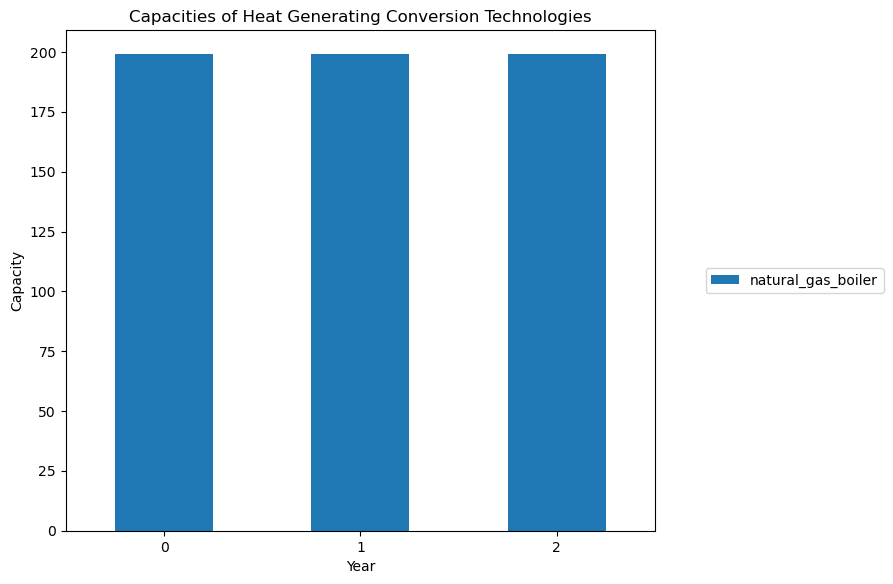

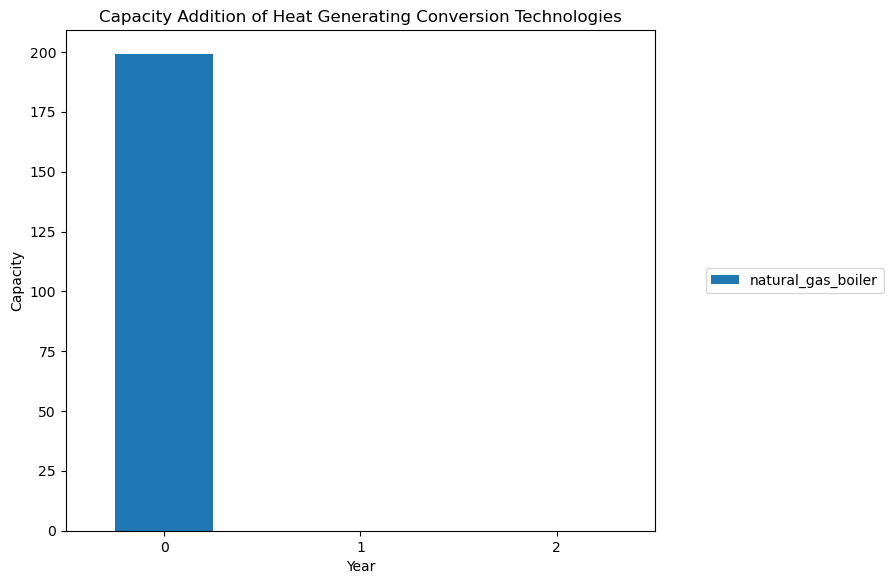

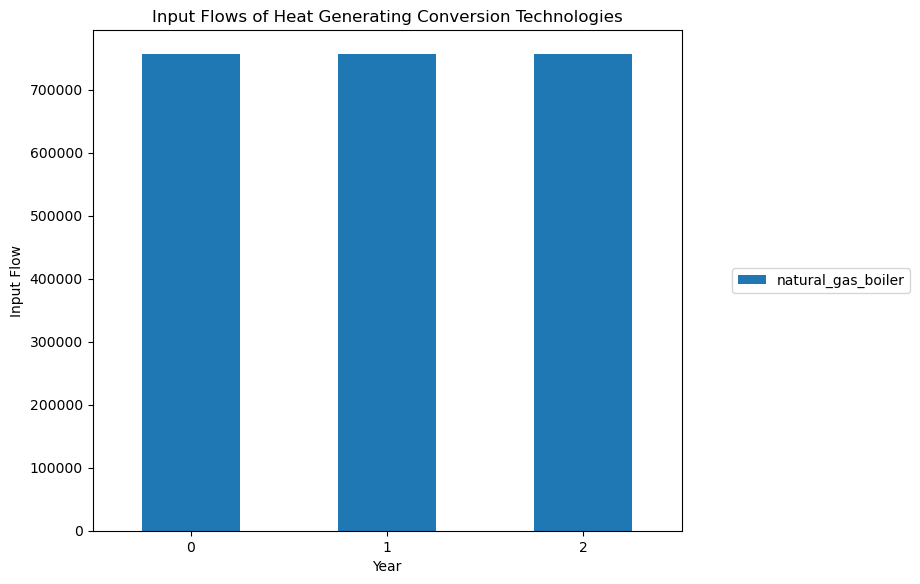

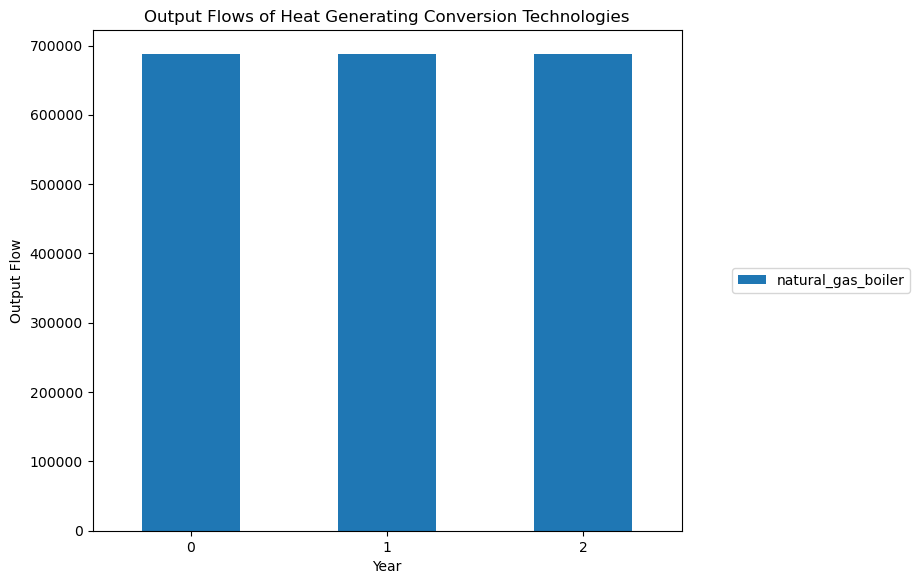

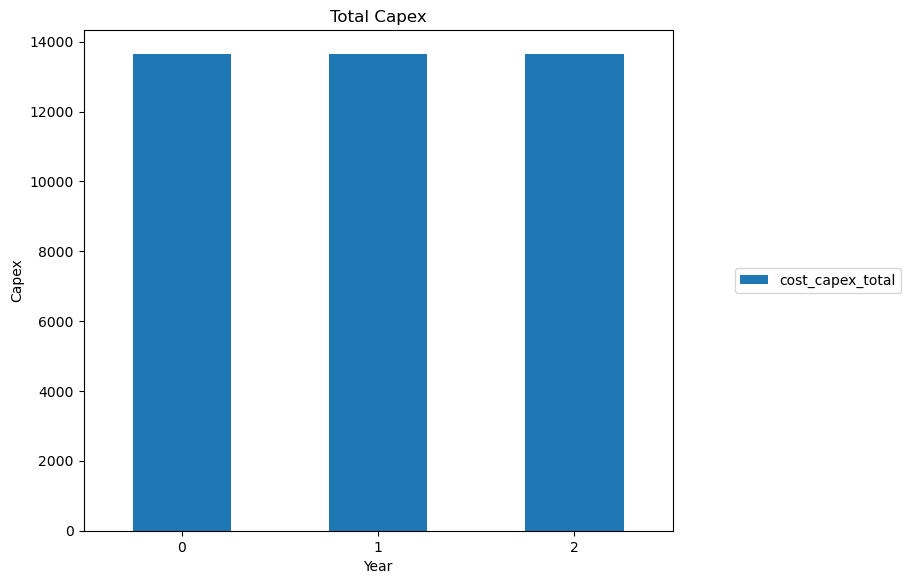

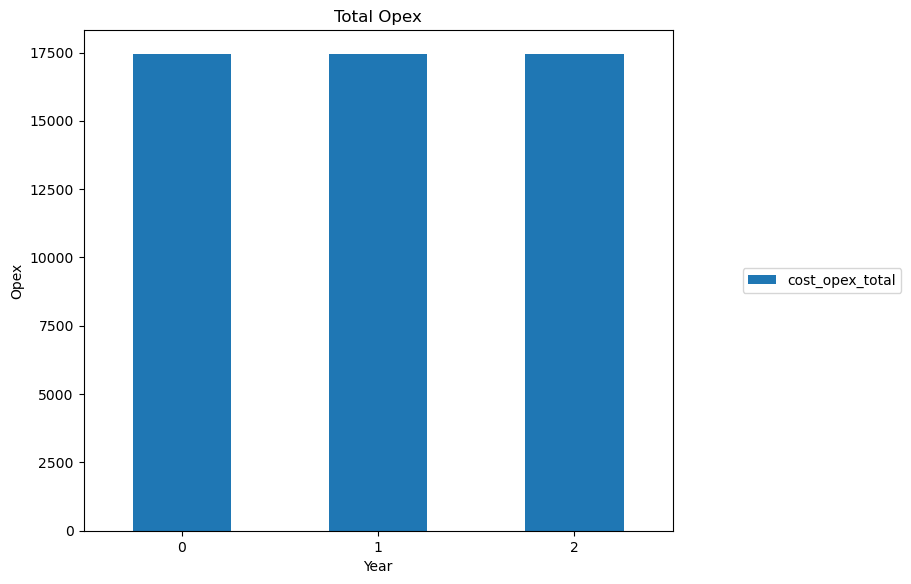

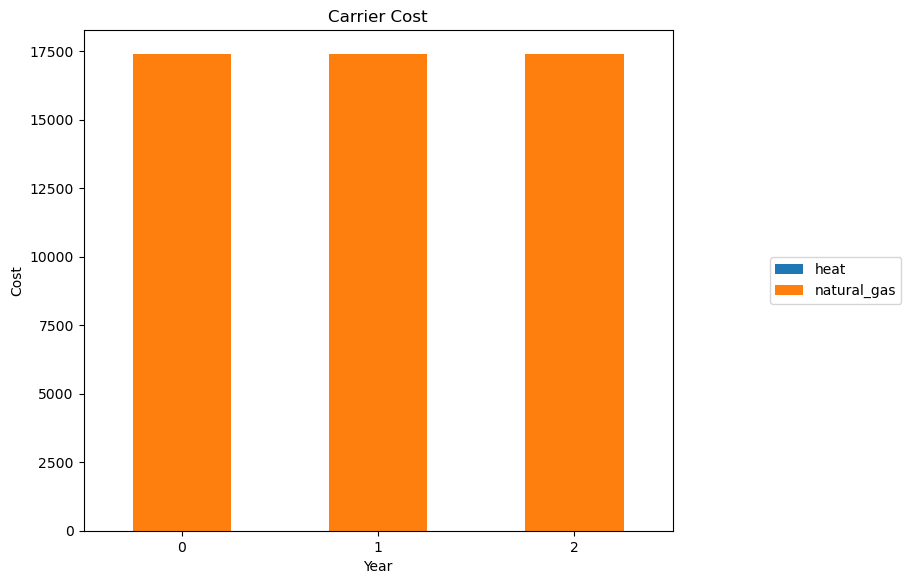

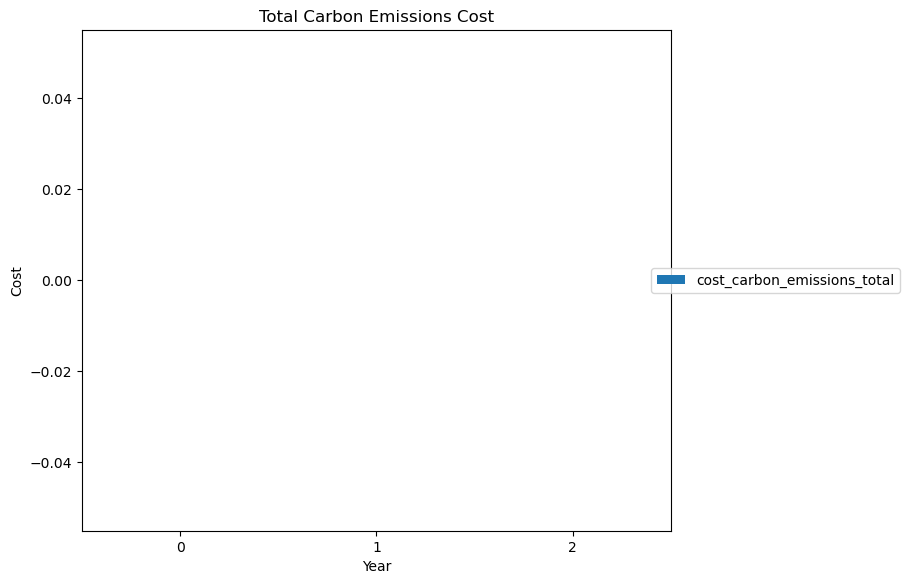

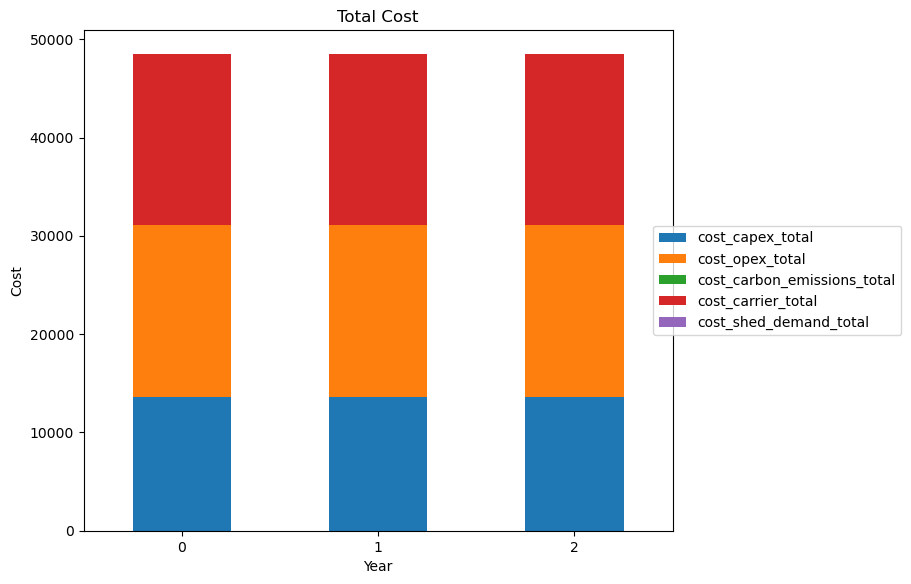

In [18]:
#Create the standard plots of your Results object (e.g. res_ts)
res_ts.standard_plots()

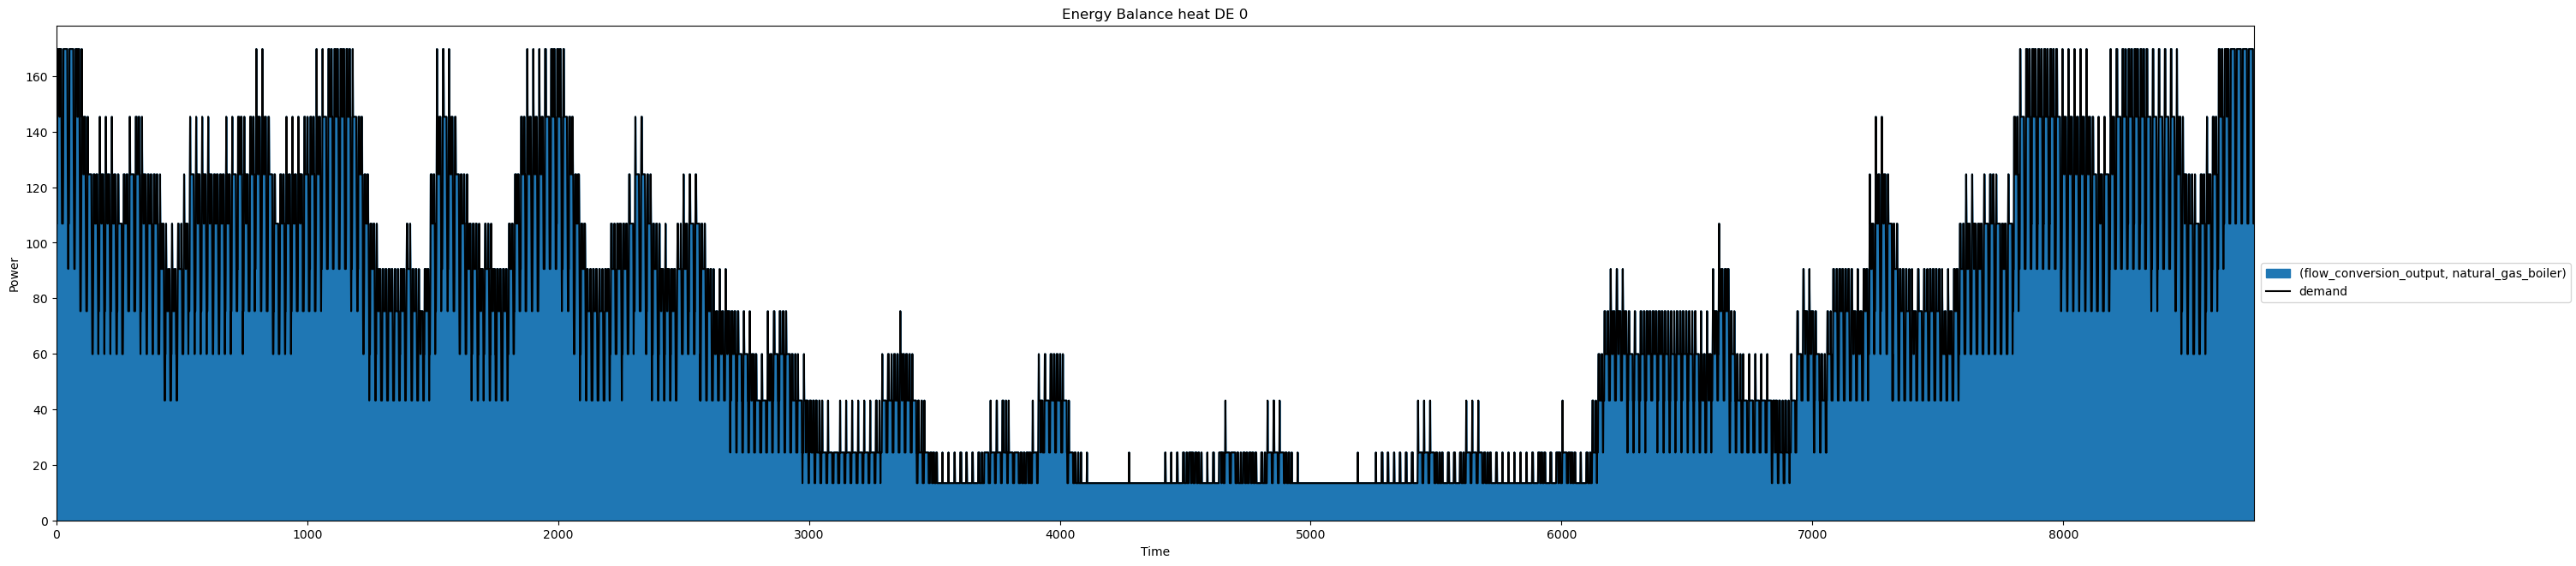

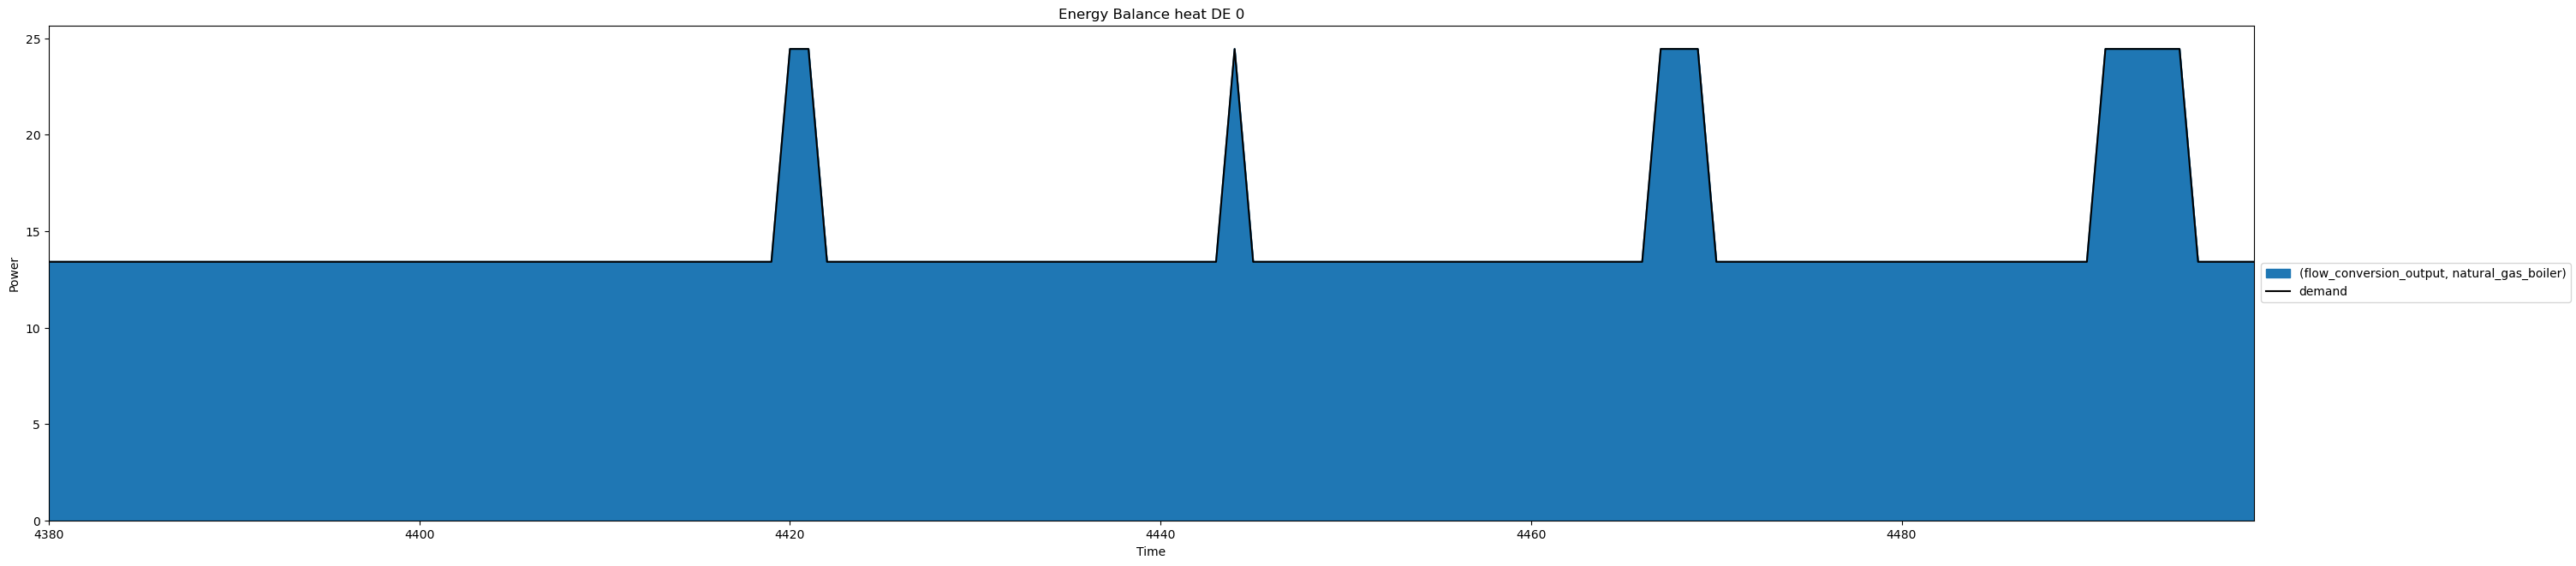

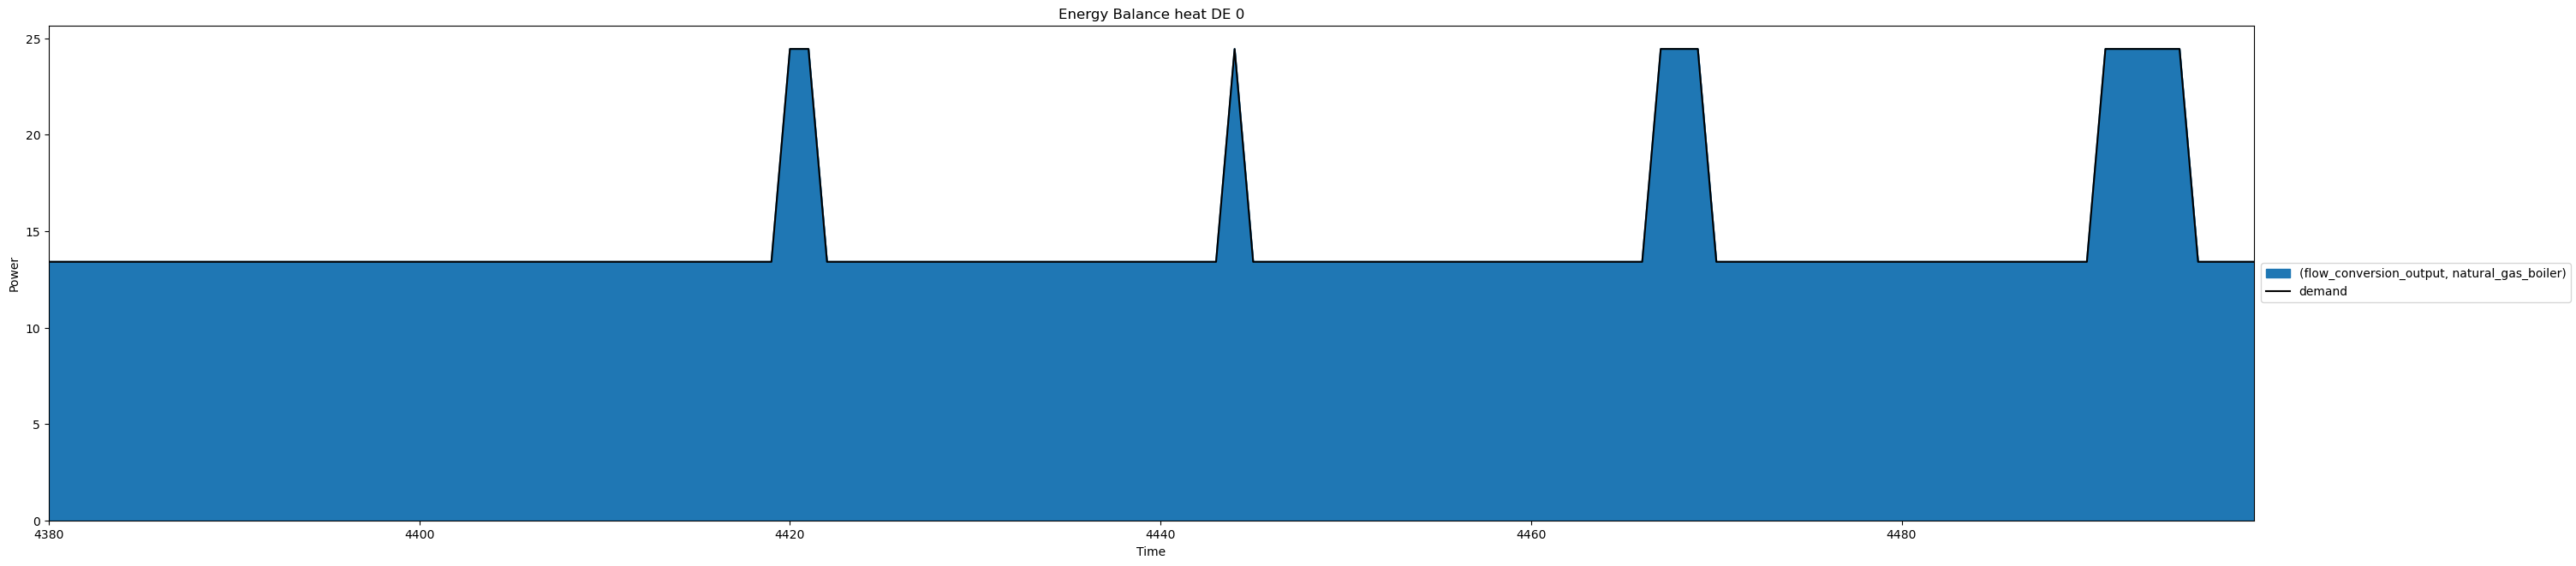

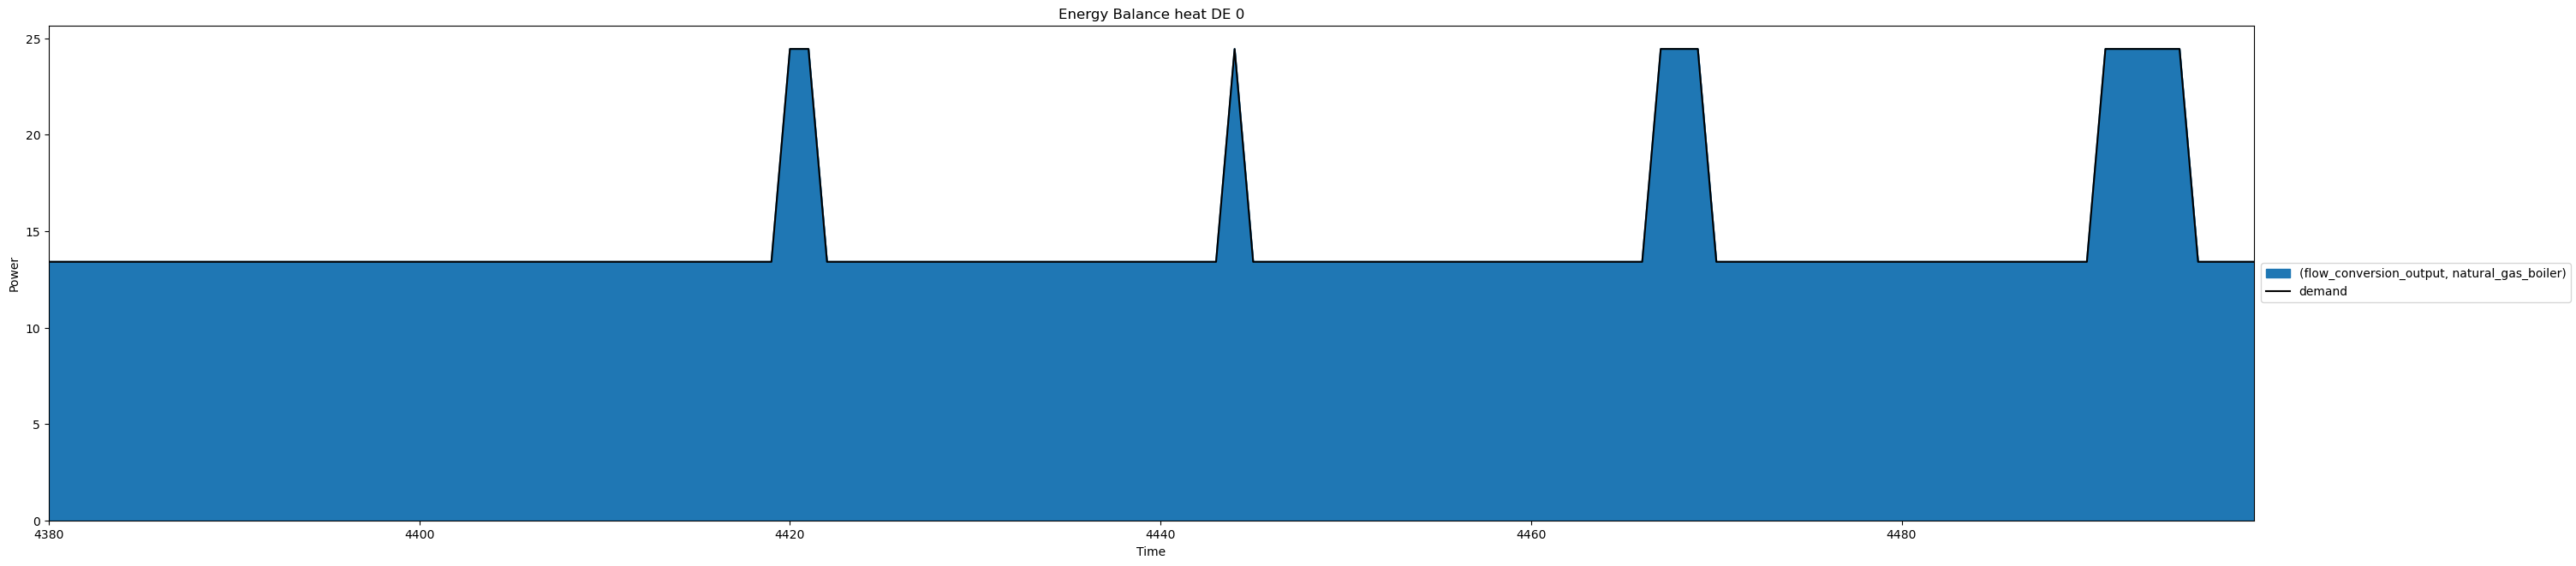

In [19]:
#Visualise the energy balance at the node Germany for the carrier heat in year 0
res_ts.plot_energy_balance("DE","heat",0)
#create a zoom-in
res_ts.plot_energy_balance("DE", "heat", 0, start_hour=int(8760/2), duration=5*24)
#save your figure as a pdf(works identically for all three plot functions)(figure is shown anyway)
res_ts.plot_energy_balance("DE", "heat", 0, start_hour=int(8760/2), duration=5*24, save_fig=True)
#save your figure in another format
res_ts.plot_energy_balance("DE", "heat", 0, start_hour=int(8760/2), duration=5*24, save_fig=True, file_type="png")

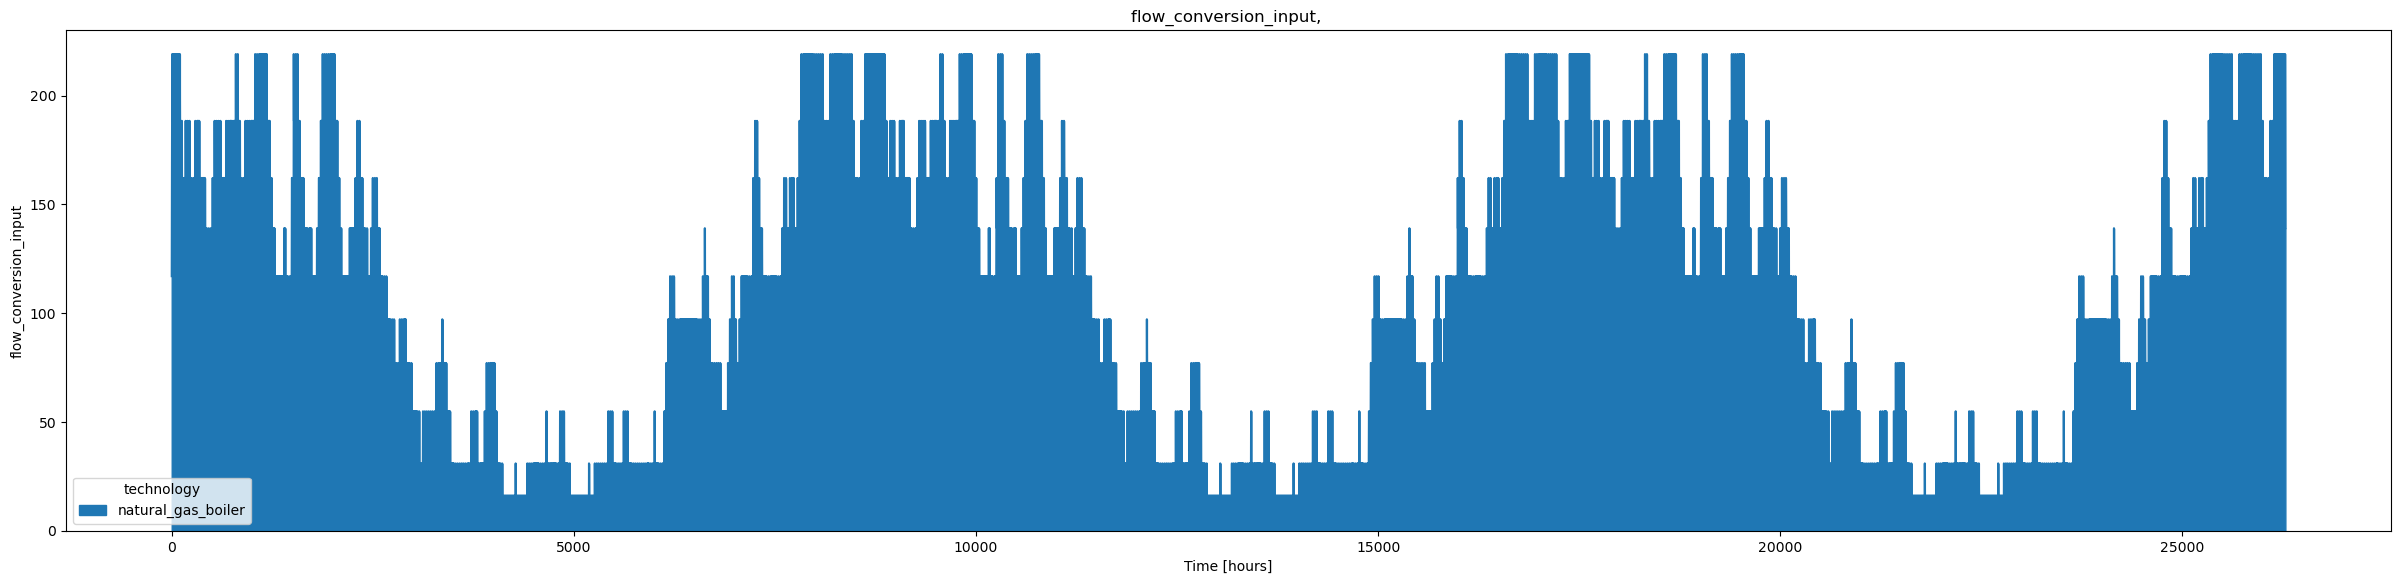

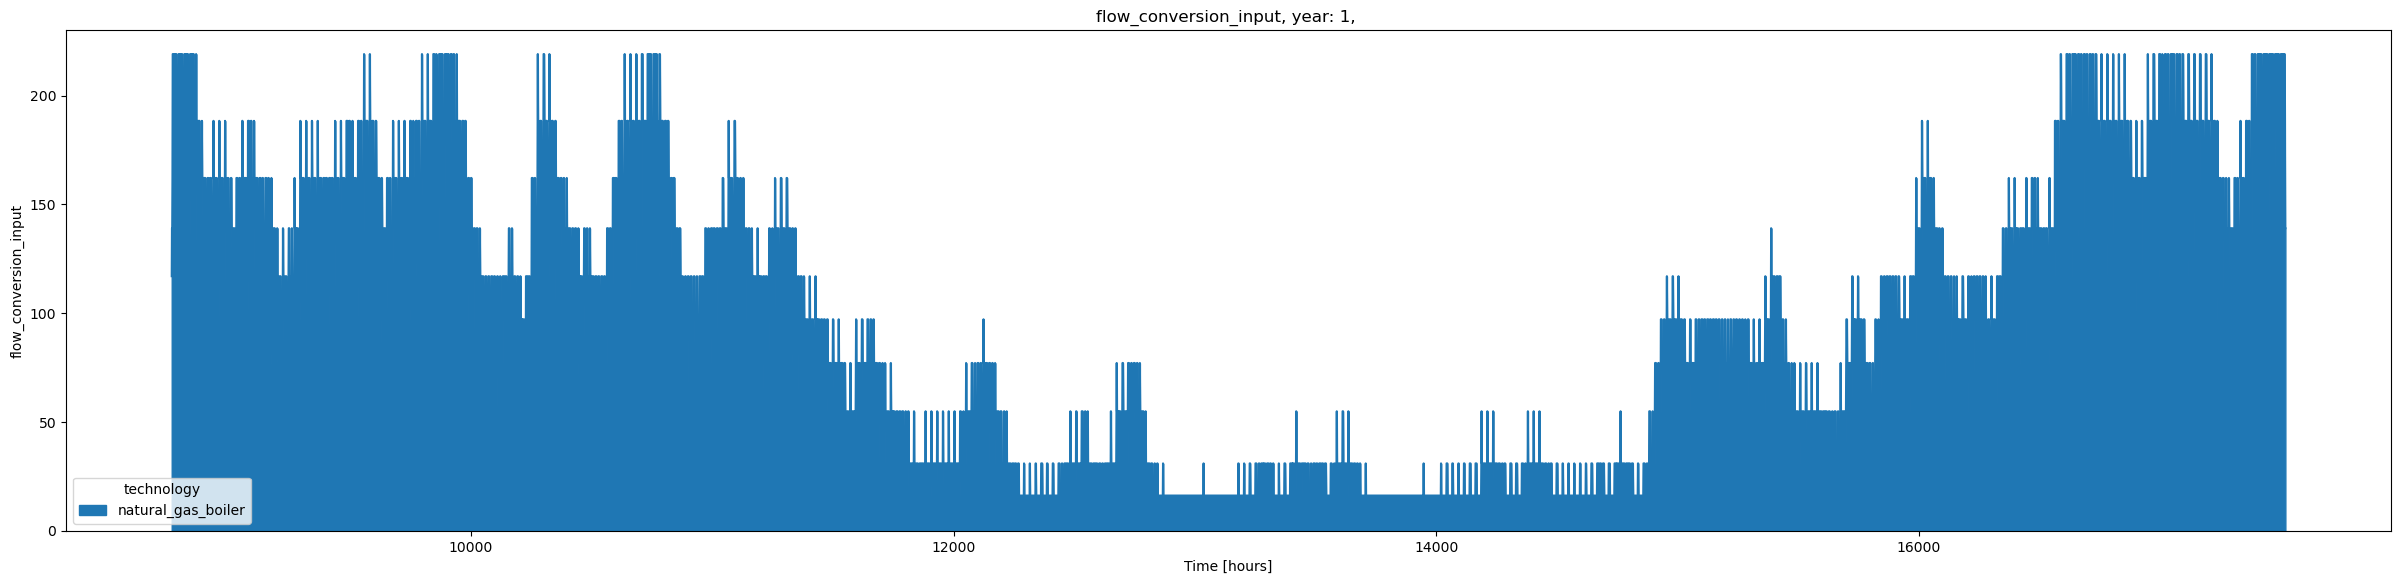

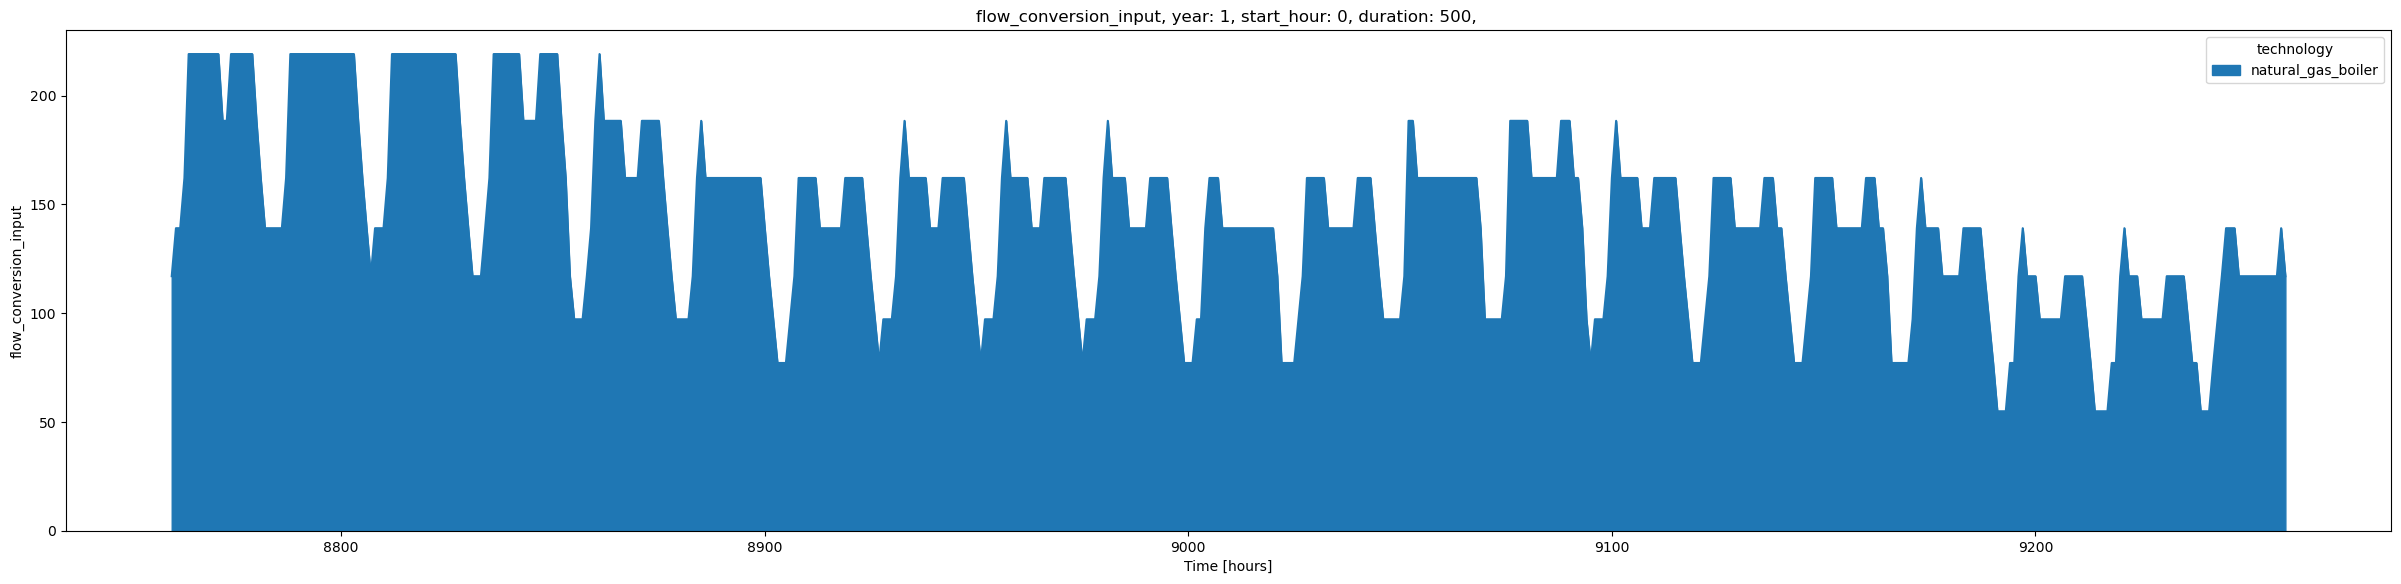

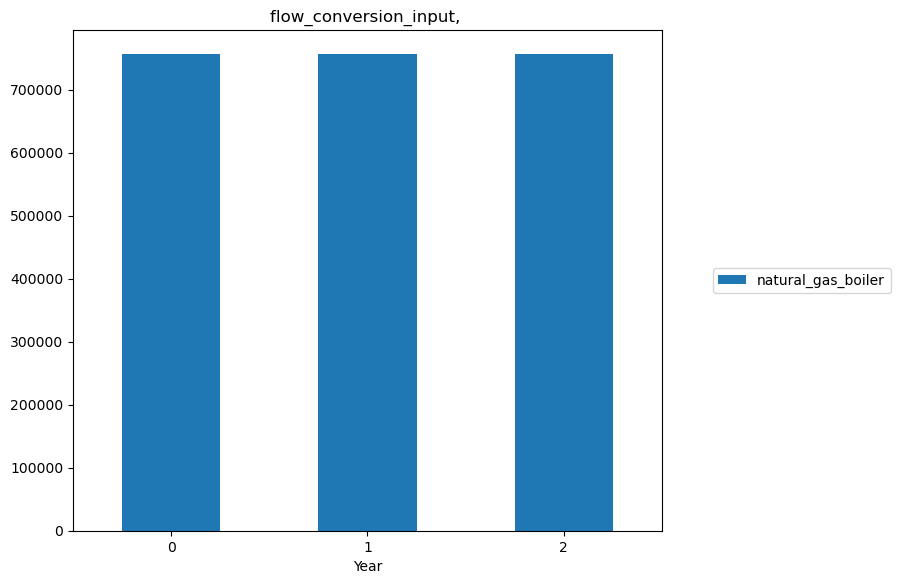

In [20]:
#Create more customized plots:
res_ts.plot("flow_conversion_input")
#time adjustments
#plot only second year
res_ts.plot("flow_conversion_input", year=1)
#create zoom-in
res_ts.plot("flow_conversion_input", year=1, start_hour=0, duration=500)
#use yearly time steps
res_ts.plot("flow_conversion_input", yearly=True)

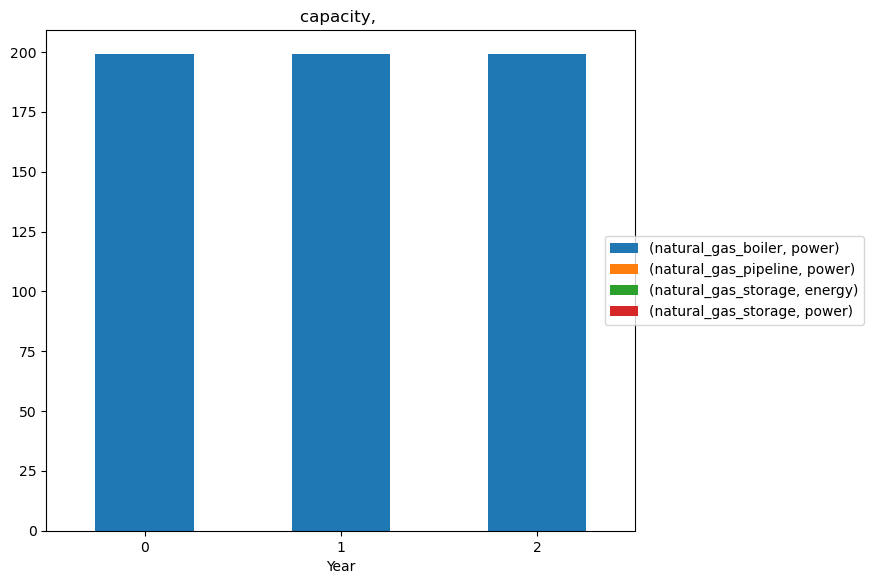

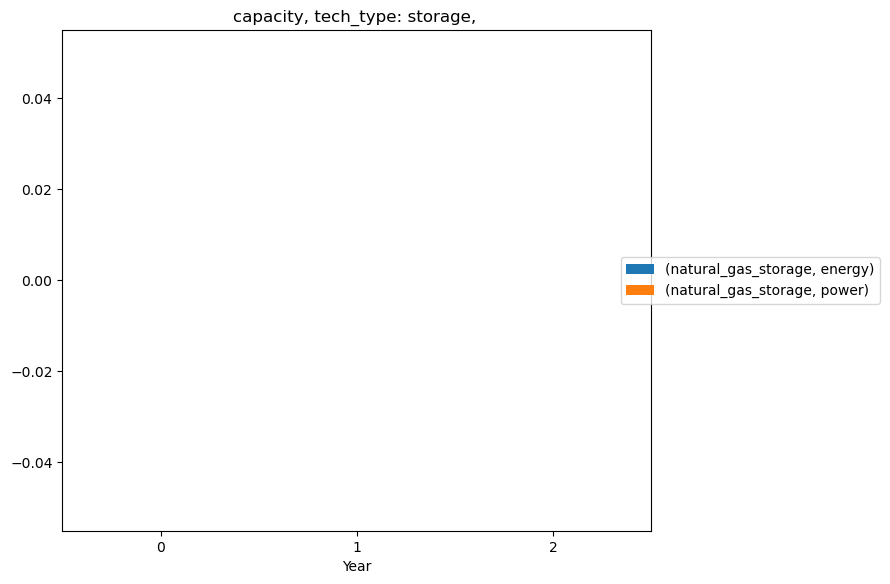

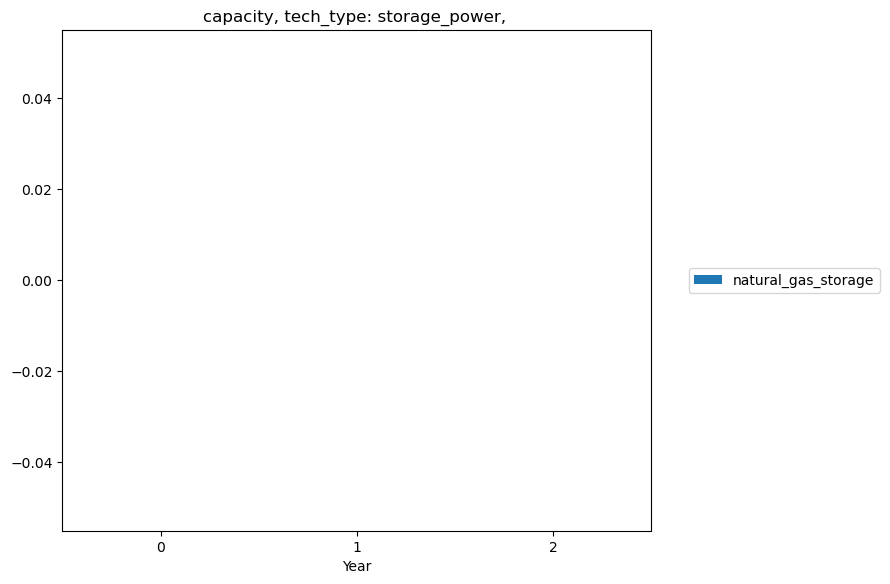

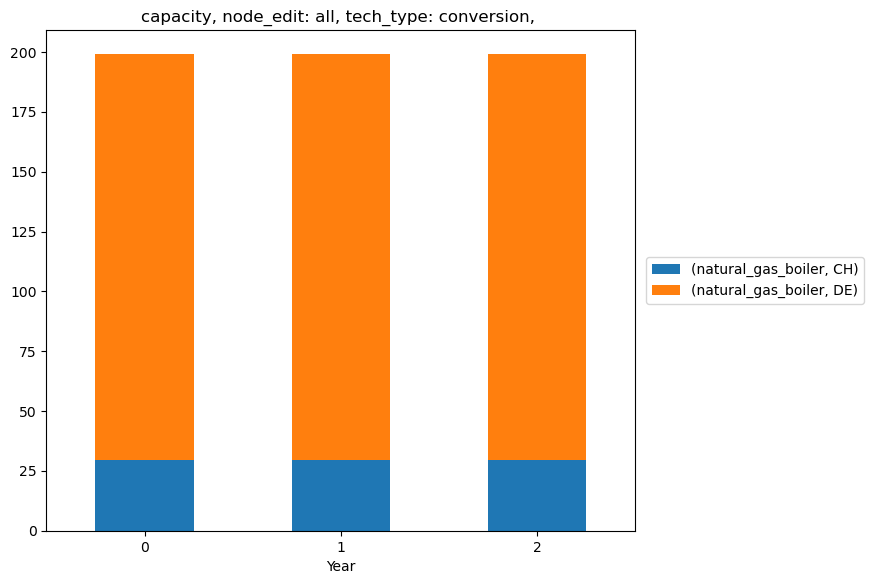

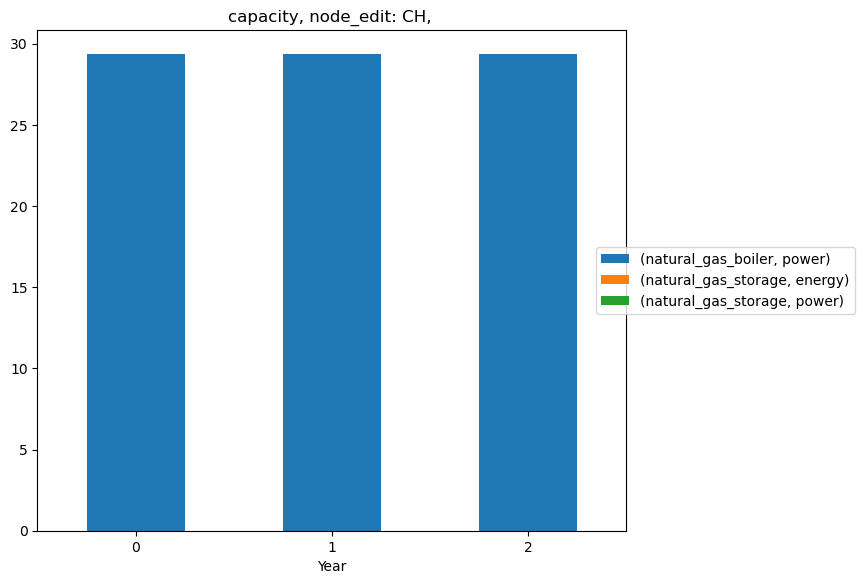

In [21]:
res_ts.plot("capacity")
#data adjustments
#plot specific technology type
res_ts.plot("capacity", tech_type="storage")
#plot charging/discharging capacities
res_ts.plot("capacity", tech_type="storage_power")
#plot all nodes separately
res_ts.plot("capacity", tech_type="conversion", node_edit="all")
#plot data of a single node
res_ts.plot("capacity", node_edit="CH")

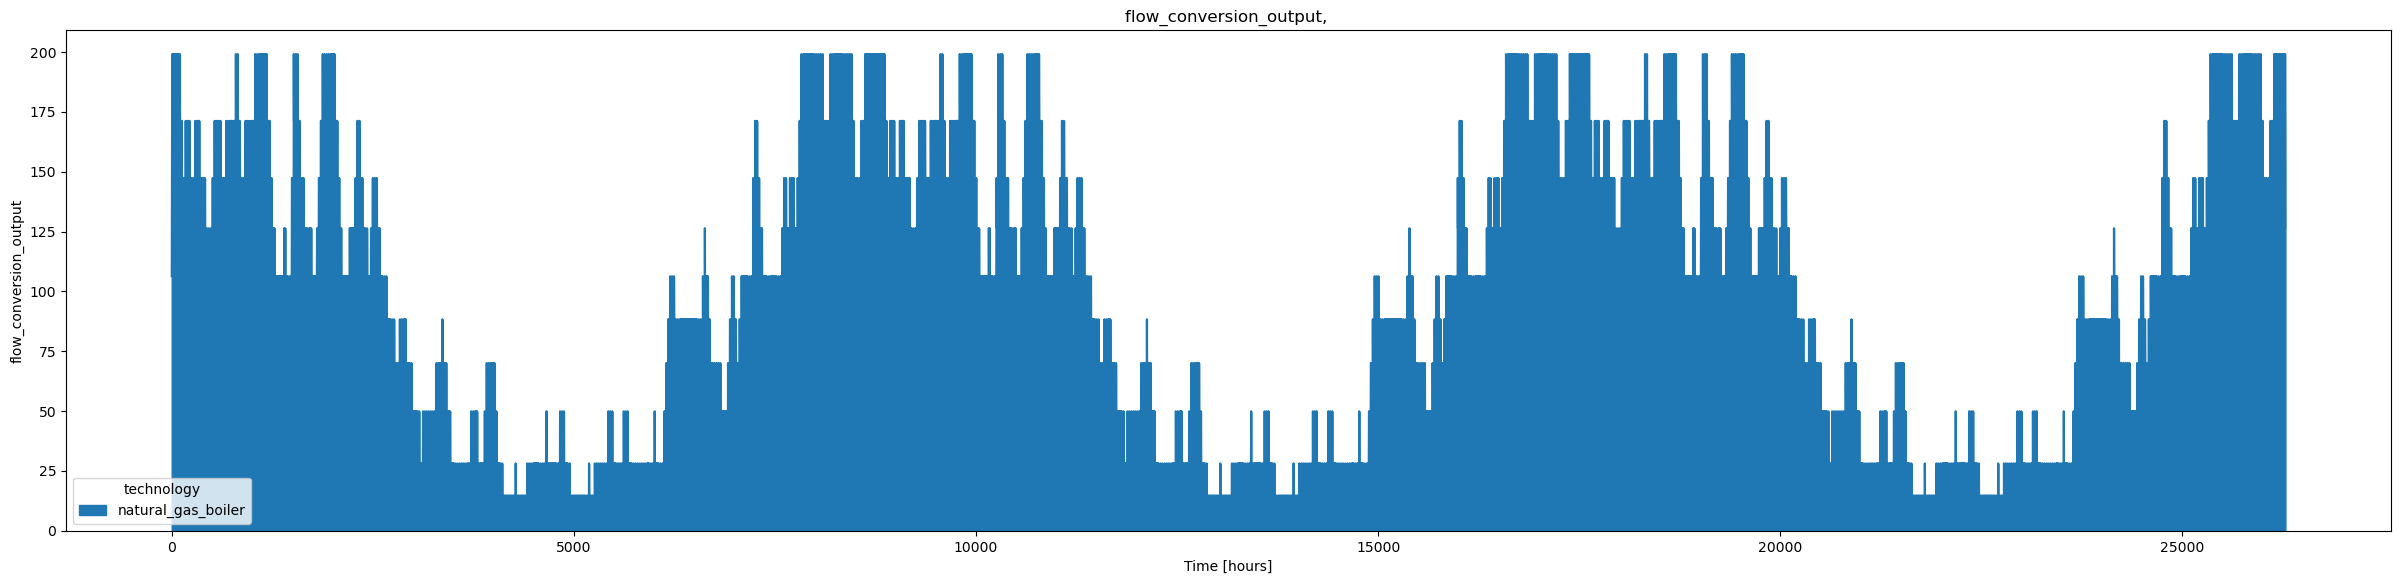

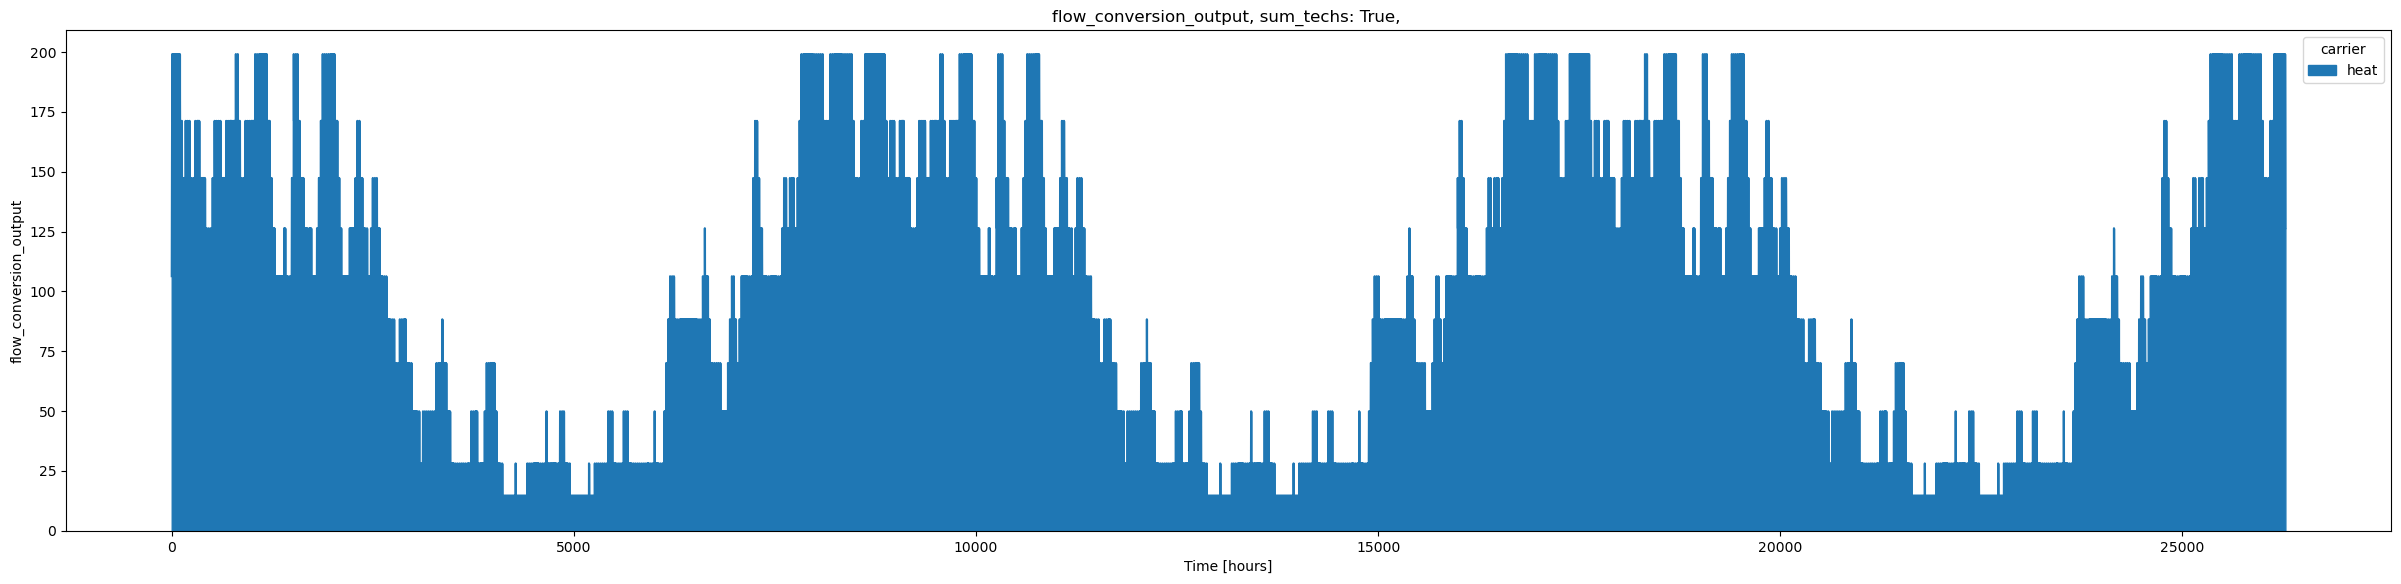

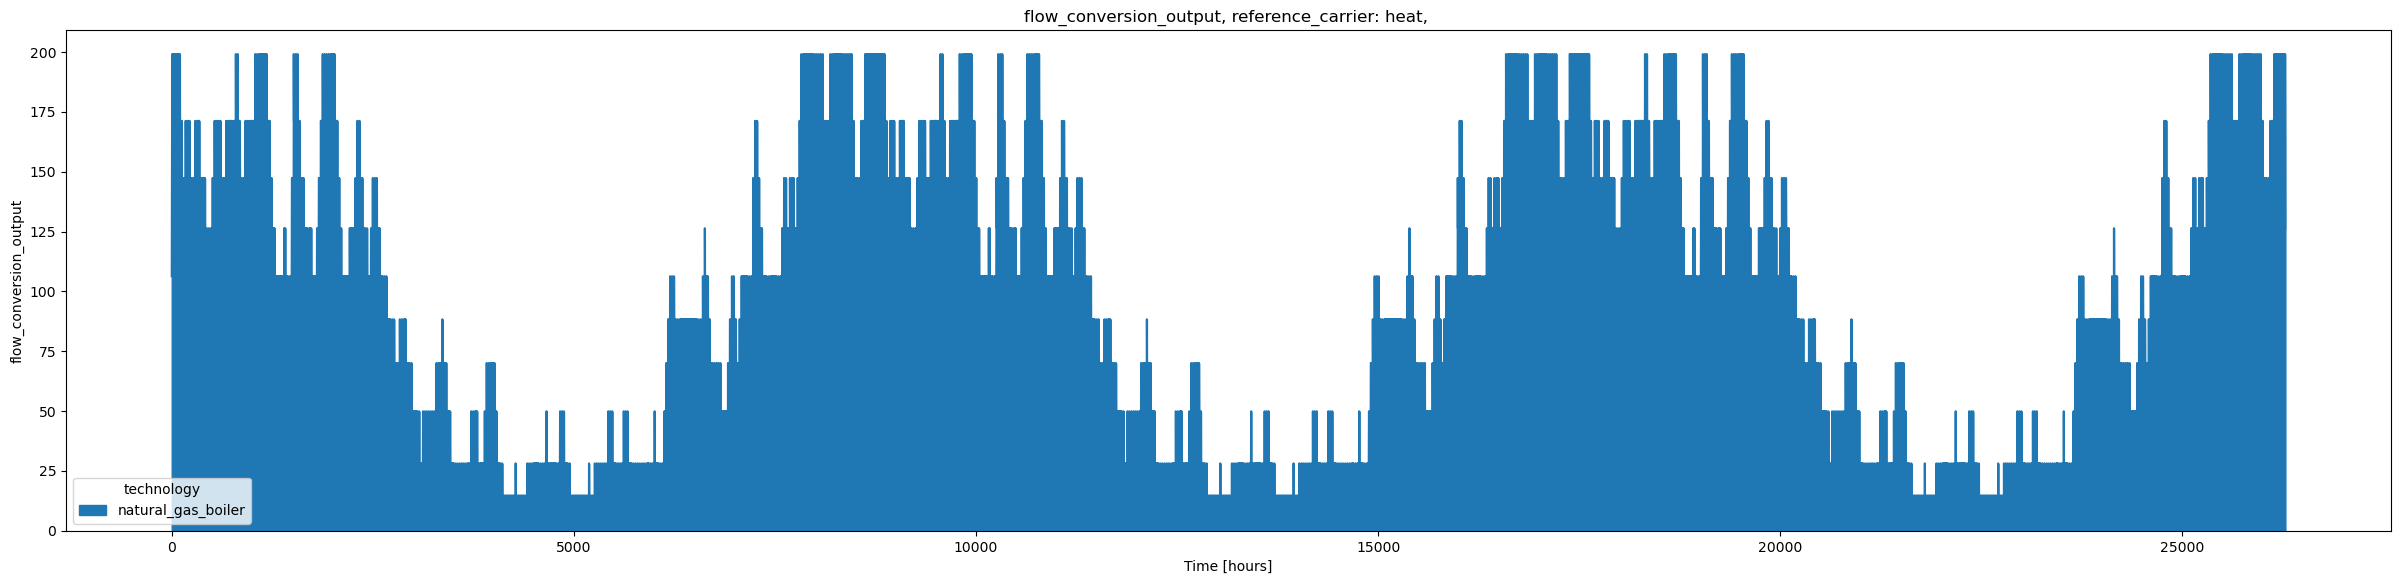

In [22]:
res_ts.plot("flow_conversion_output")
#sum technologies of identical output carrier (effect can't really be seen as there is only one tech in the dataset)
res_ts.plot("flow_conversion_output", sum_techs=True)
#extract technologies of specific reference carrier (effect can't really be seen as there is only one tech in the dataset)
res_ts.plot("flow_conversion_output", reference_carrier="heat")

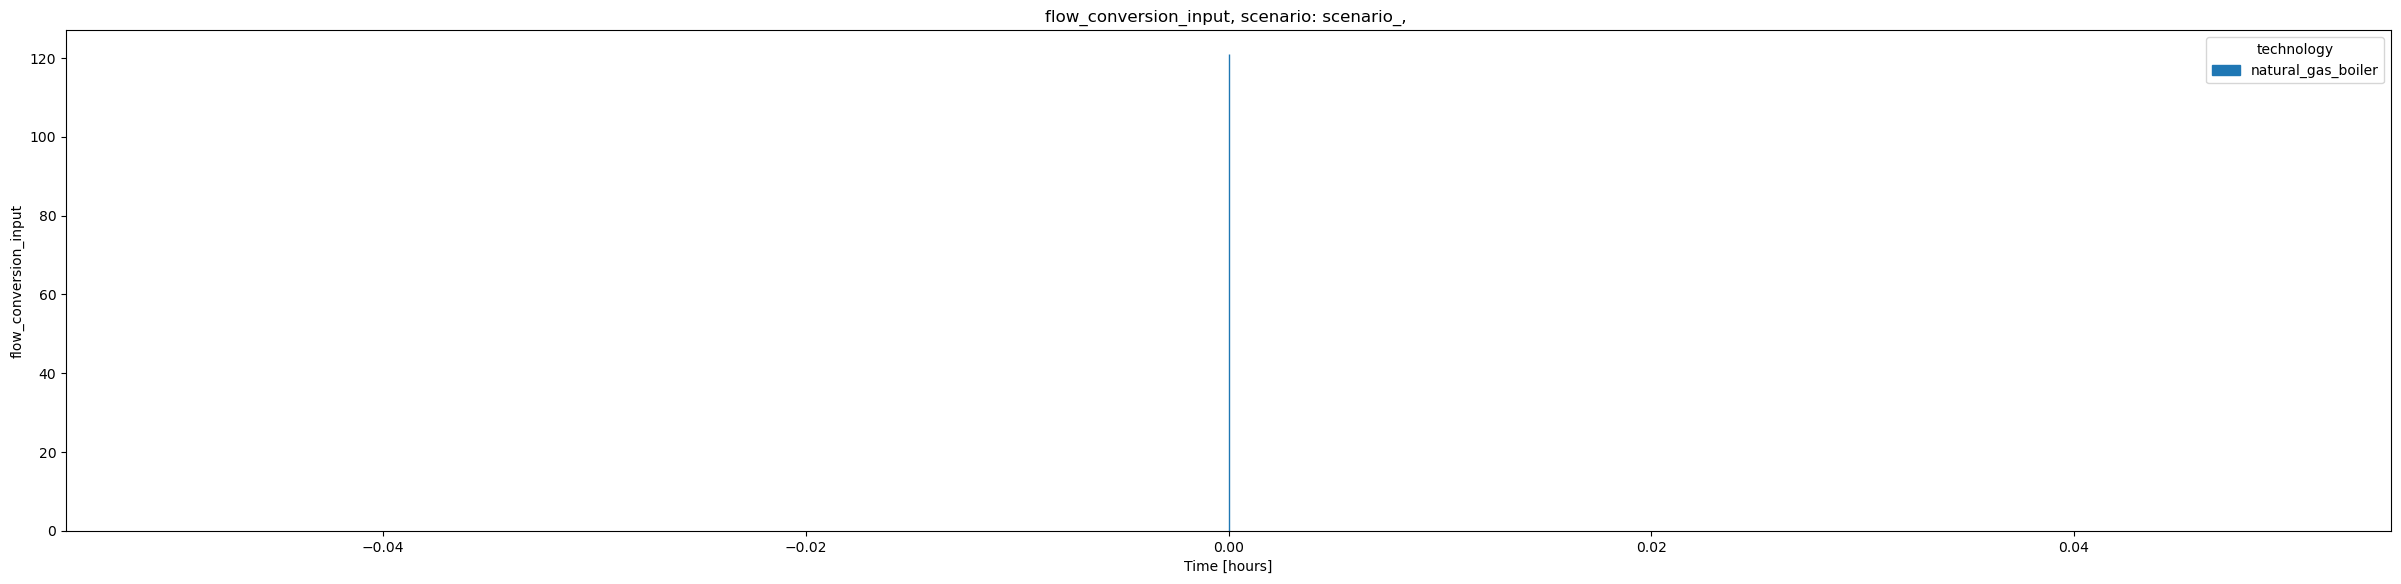

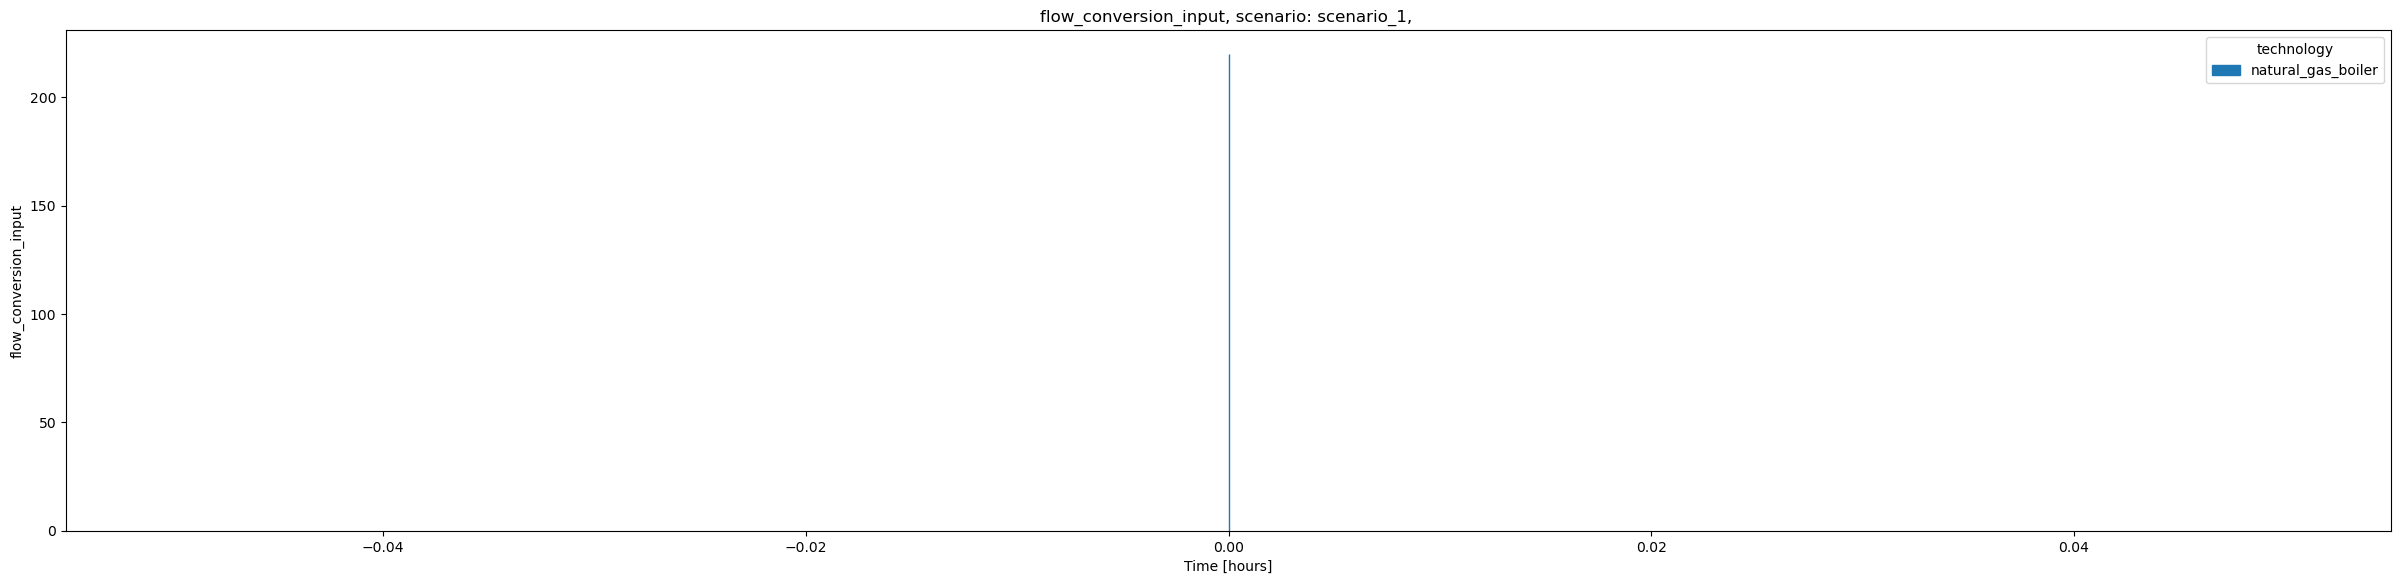

In [23]:
#create plot of multi-scenario dataset (standard scenario is plotted)
res_scenario.plot("flow_conversion_input")
#specify another scenario
res_scenario.plot("flow_conversion_input", scenario="scenario_1")